In [1]:
import metrics
import train
import utils 
import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

from datasets import load_dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/rxu/miniconda3/envs/exp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-04 19:39:23.715544: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-04 19:39:23.753795: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 19:39:24.438738: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not 

INFO:datasets:PyTorch version 2.3.1+cu121 available.
INFO:datasets:TensorFlow version 2.16.1 available.


In [2]:
def transform(examples):
    examples['image'] = [transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])(img) for img in examples['image']]
    return examples

ds_dalle = load_dataset("OpenDatasets/dalle-3-dataset", ignore_verifications=True,  split='train[:5%]')
ds_dalle.set_transform(transform)
dataloader = torch.utils.data.DataLoader(ds_dalle, batch_size=1, shuffle=True, num_workers=0)

/home/rxu/miniconda3/envs/exp/lib/python3.11/site-packages/datasets/load.py:2562: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


In [3]:
ckpt_path = '../saved_ckpts/paper.ckpt'
state_dict = torch.load(ckpt_path)
cfg = state_dict['config']
wm_model = train.Watermark(cfg)
wm_model.load_model(ckpt_path)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/rxu/miniconda3/envs/exp/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rxu/miniconda3/envs/exp/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/rxu/miniconda3/envs/exp/lib/python3.11/site-packages/lpips/weights/v0.1/vgg.pth
INFO:train:Loading model from epoch:49


## Apply transformation to the encoded images

In [11]:
for idx, eval_batch in enumerate(dataloader):
    inputs = eval_batch['image']
    secret, _ = utils.uuid_to_bits(inputs.shape[0])
    secret = secret[:, :100].to(device)
    final_output, enc_input, enc_output = wm_model._encode(inputs, secret)

    psnr = metrics.image_psnr(inputs, final_output.cpu()).detach().numpy()
    ssim = metrics.image_ssim(inputs, final_output.cpu()).detach().numpy()
    extracted_secret = wm_model._decode(final_output)
    bitAcc = metrics.bit_accuracy(extracted_secret, secret)
    print(f"PSNR: {psnr}, SSIM: {ssim}, BitAcc: {bitAcc}")
    break

PSNR: 51.4217529296875, SSIM: 0.9988216161727905, BitAcc: tensor([1.])


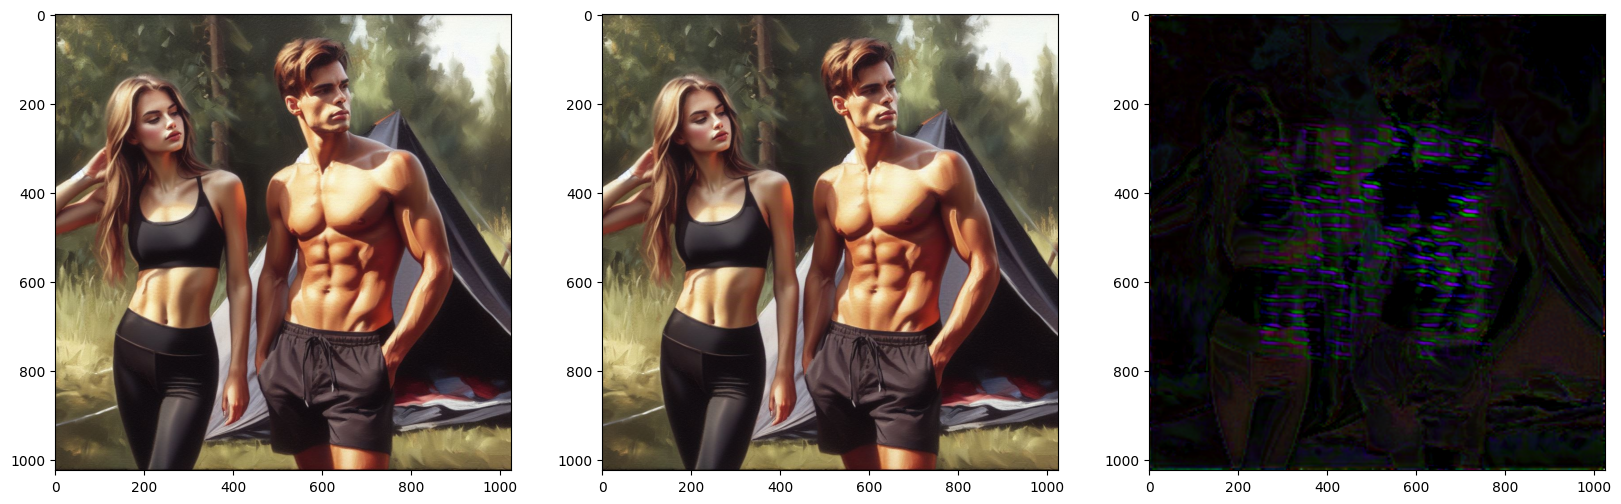

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
ax[0].imshow(np.transpose(vutils.make_grid(inputs[0], padding=2, normalize=True, value_range=(-1,1)).cpu(),(1,2,0)))
ax[1].imshow(np.transpose(vutils.make_grid(final_output[0].detach(), padding=2, normalize=True, value_range=(-1,1)).cpu(),(1, 2, 0)))
ax[2].imshow(np.transpose(vutils.make_grid((final_output[0].cpu().detach()-inputs[0])*20., padding=2, value_range=(-1,1)).cpu(),(1, 2, 0)))